**Dataset Modeling - XGBoost**

In [ ]:
import rpy2
import pandas as pd 
import numpy as np
import os 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

#!pip install sklearn
df = pd.read_csv('ExportedSubsetData.csv')
#Print data frame
df
#Dataset Info Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


**1. Data Cleaning**

In [ ]:
# 1.1 - Removing Variables not needed for Calssification
newData = df.drop(['isFlaggedFraud','nameOrig', 'nameDest'], axis=1)
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   oldbalanceOrg   50000 non-null  float64
 4   newbalanceOrig  50000 non-null  float64
 5   oldbalanceDest  50000 non-null  float64
 6   newbalanceDest  50000 non-null  float64
 7   isFraud         50000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 3.1+ MB


In [ ]:
# 1.2 - Retaining only CASH-OUT and TRANSFER transactions
newData = newData.loc[newData['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new data now has', len(newData), ' transations.')

The new data now has 21879  transations.


In [ ]:
# 1.3 - Converting categorical varaible to numeric representation
# Encoding categorical "type" variable to convert transation type to binary variables
newData = pd.get_dummies(newData, columns=['type'], prefix=['type'])
newData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21879 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            21879 non-null  int64  
 1   amount          21879 non-null  float64
 2   oldbalanceOrg   21879 non-null  float64
 3   newbalanceOrig  21879 non-null  float64
 4   oldbalanceDest  21879 non-null  float64
 5   newbalanceDest  21879 non-null  float64
 6   isFraud         21879 non-null  int64  
 7   type_CASH_OUT   21879 non-null  uint8  
 8   type_TRANSFER   21879 non-null  uint8  
dtypes: float64(5), int64(2), uint8(2)
memory usage: 1.4 MB


In [ ]:
# Print first 5 rows
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,182,129804.96,0.00,0.0,4225880.68,4355685.64,0,1,0
4,252,61214.57,0.00,0.0,364102.11,425316.68,0,1,0
5,18,125379.52,0.00,0.0,883177.46,1120071.12,0,1,0
6,331,30449.41,0.00,0.0,456924.04,487373.45,0,1,0
7,277,157649.53,7660.25,0.0,491363.14,649012.67,0,1,0


In [ ]:
# To check min value of a feature. For Example:
newData['step'].min()

1

In [ ]:
# To check max value of a feature. For Example:
newData['step'].max()

742

**2. Data Normalization**

In [ ]:
# 2.1 (a) - Standardizing the Data or Scale Data using MinMaxScaler to convert the value between the min and max
# https://www.youtube.com/watch?v=sFVxFCYiIQI (15:00)
from sklearn.preprocessing import MinMaxScaler
scale_vars = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud' ]
scaler = MinMaxScaler()
newData[scale_vars] = scaler.fit_transform(newData[scale_vars])
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.003076,0.000000,0.0,0.026917,0.027718,0.0,1,0
4,0.338731,0.001450,0.000000,0.0,0.002319,0.002707,0.0,1,0
5,0.022942,0.002971,0.000000,0.0,0.005626,0.007128,0.0,1,0
6,0.445344,0.000721,0.000000,0.0,0.002910,0.003102,0.0,1,0
7,0.372470,0.003736,0.000175,0.0,0.003130,0.004130,0.0,1,0


In [ ]:
# 2.1 (b) - Data Normalization using the Min-Max Method 
normalized_df = newData.copy()

for column in normalized_df.columns:
  normalized_df[column] = (normalized_df[column] - normalized_df[column].min())/(normalized_df[column].max() - normalized_df[column].min())
normalized_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.003076,0.000000,0.0,0.026917,0.027718,0.0,1.0,0.0
4,0.338731,0.001450,0.000000,0.0,0.002319,0.002707,0.0,1.0,0.0
5,0.022942,0.002971,0.000000,0.0,0.005626,0.007128,0.0,1.0,0.0
6,0.445344,0.000721,0.000000,0.0,0.002910,0.003102,0.0,1.0,0.0
7,0.372470,0.003736,0.000175,0.0,0.003130,0.004130,0.0,1.0,0.0


In [ ]:
# 2.1 (c) - Standardizing the Data: converting all columns to have the same range
# Normalization of dataset
std_scaler = StandardScaler()
data_scaled = pd.DataFrame(std_scaler.fit_transform(newData.loc[:,~newData.columns.isin(['isFraud'])]))
data_scaled.columns = newData.columns[:-1]
data_scaled['isFraud'] = newData['isFraud']

In [ ]:
# To validate min value of a feature has been converted. For Example:
newData['step'].min()

0.0

In [ ]:
# To validate max value of a feature has been converted. For Example:
newData['step'].max()

0.9999999999999999

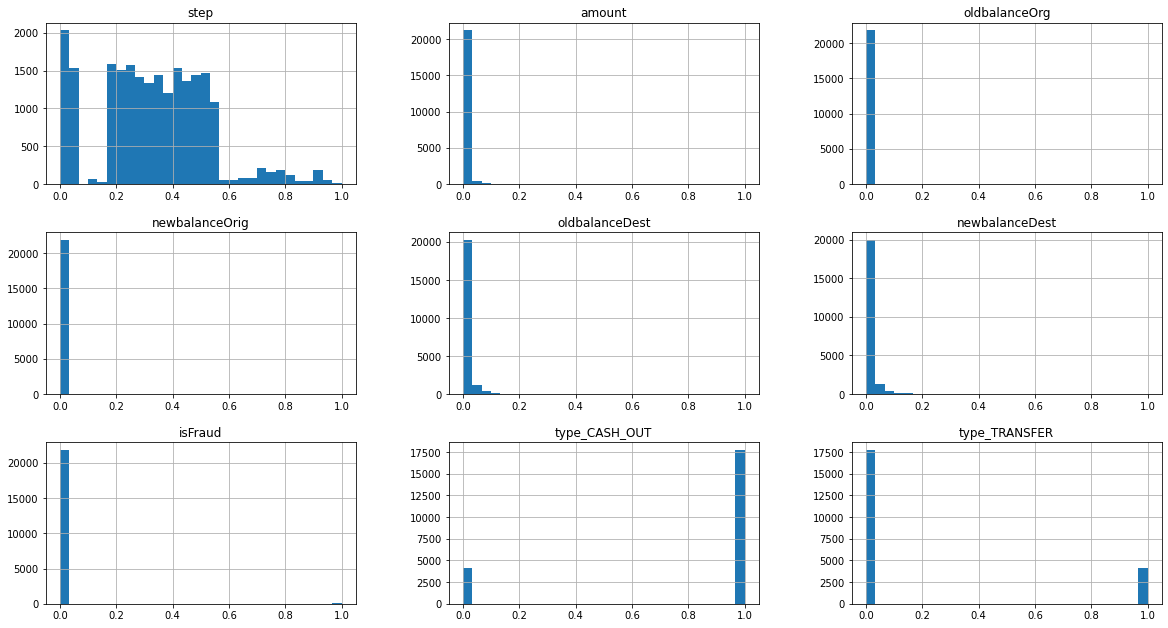

In [ ]:
# 2.2 - Visualize distributions
newData.hist(bins=30, figsize=(20,30), layout=(8,3));

In [ ]:
# 2.3 - Transformation of Independent Variables with visually non-normal distributions 
normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']] = normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']].applymap(lambda x: np.log(1+x))

normalized_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
count,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000
mean,0.271409,0.007560,0.001104,0.000364,0.010620,0.012774,0.002154,0.810046,0.189954
std,0.144908,0.019878,0.006662,0.005033,0.022766,0.025241,0.038583,0.392273,0.392273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188823,0.001944,0.000000,0.000000,0.000867,0.002119,0.000000,1.000000,0.000000
50%,0.275462,0.004021,0.000006,0.000000,0.003567,0.005284,0.000000,1.000000,0.000000
75%,0.370213,0.007182,0.000701,0.000000,0.011085,0.013629,0.000000,1.000000,0.000000
max,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,1.000000,1.000000


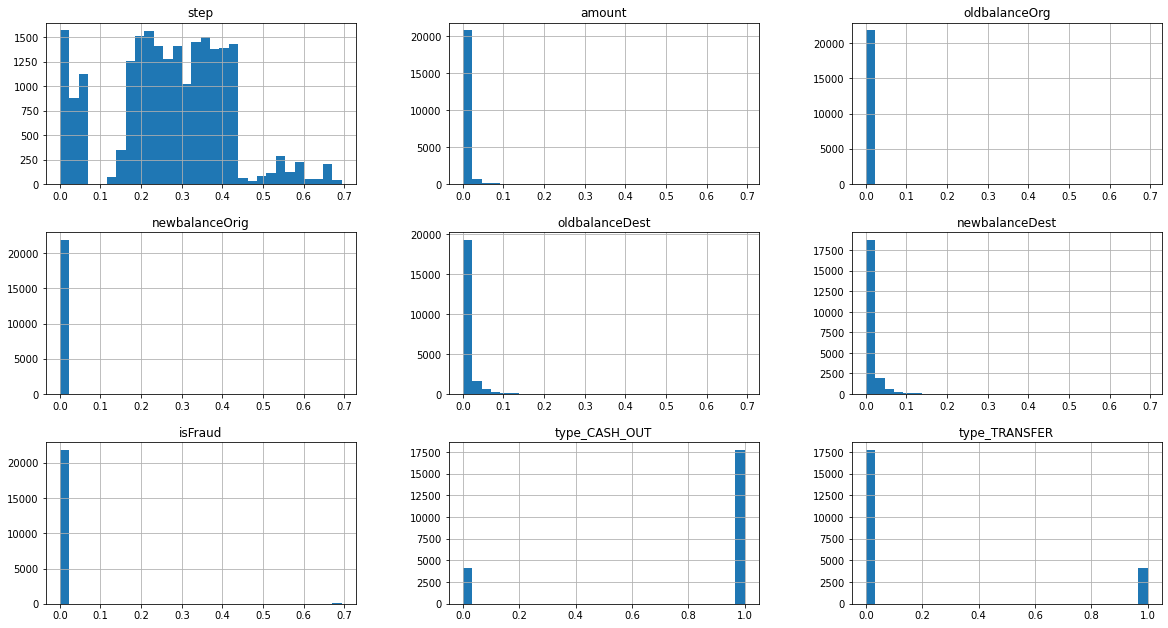

In [ ]:
# Visualize distributions
normalized_df.hist(bins=30, figsize=(20,30), layout=(8,3));

**3.	Create Train and Test Datasets**

In [ ]:
# 3.1 - Split the scaled cleaned dataset into 70%  training and 30% testing datasets
# https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# Model building in Scikit-learn
# Split dataset into feature (independant variable) and target variable (isFraud)
feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable

# Split X and y into training and testing datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
# 3.2 - SMOT
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# 3.3 - Check class imbalance in Train and Test Datasets
#Class Imbalance - Percentage Frequency
dFraud = pd.DataFrame(y_train_original, columns= ['isFraud'])
# Percentage calculation
(dFraud['isFraud'].value_counts()/dFraud['isFraud'].count())*100

2    56.271629
0    43.578191
1     0.150180
Name: isFraud, dtype: float64

In [ ]:
# 3.4 - Class Imbalance - Percentage Frequency
dFraud = pd.DataFrame(y_test_original, columns= ['isFraud'])
# Percentage calculation
(dFraud['isFraud'].value_counts()/dFraud['isFraud'].count())*100

2    56.170018
0    43.723339
1     0.106642
Name: isFraud, dtype: float64

**4. Setup XGBoost Model**

In [ ]:
# 4.1 - Import and setup XGBoost Model
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#from xgboost.xgbclassifier import XGBClassifier
#from sklearn.datasets import make_classification
scr = 'recall'
accuracy_dict = {}
model_xgb = xgb.Booster()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Stratified 5-fold cross-validation: to ensure models do not overfit the training data
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5)

In [ ]:
# 4.2 - Separate the target variable and rest of the variables using .iloc to subset the data.
# Run #1 to #4
X, y = newData.iloc[:,:-1],newData.iloc[:,-1]

In [ ]:
# 4.3 - Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed 
# performance and efficiency gains.
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
# **4.4 (CHECK IF TO BE REPLACED BY 3.1) - Create the train and test set for cross-validation of the results using the train_test_split function from 
# sklearn's model_selection module with test_size size equal to 30% of the data. Also, to maintain reproducibility of 
# the results, a random_state is also assigned.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
# **4.5 - SMOT (CHECK IF TO BE REPLACED BY 3.2) 
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# 4.4 - Instantiate an XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the 
# hyper-parameters passed as arguments. For classification problems, you would have used the XGBClassifier() class.
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
# 4.5 - Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[04:20:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# 4.6 - Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.
# Result: RMSE for the price prediction came out to be around 0.36 per 1000$.
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.403770


In [ ]:
# 4.7 - Verify using stratify worked: if both test and train dataset have same percentage
# https://www.bing.com/videos/search?q=XGBoost+in+Python+from+Start+to+Finish+-+YouTube&view=detail&mid=690E97BB3131F954B74E690E97BB3131F954B74E&FORM=VIRE
# min:38
X_train, X_test, y_train, y_test = train_test_split(newData, y, random_state=42, stratify=y)
sum(y_train)/len(y_train)

ValueError: ignored

In [ ]:
sum(y_test)/len(y_test)

0.1858622790981109

**Build XGBoost Model for Classification**

In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:1
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:1
[2]	validation_0-aucpr:1
[3]	validation_0-aucpr:1
[4]	validation_0-aucpr:1
[5]	validation_0-aucpr:1
[6]	validation_0-aucpr:1
[7]	validation_0-aucpr:1
[8]	validation_0-aucpr:1
[9]	validation_0-aucpr:1
[10]	validation_0-aucpr:1
Stopping. Best iteration:
[0]	validation_0-aucpr:1



XGBClassifier(seed=42)

Text(0.5, 257.44, 'Predicted label')

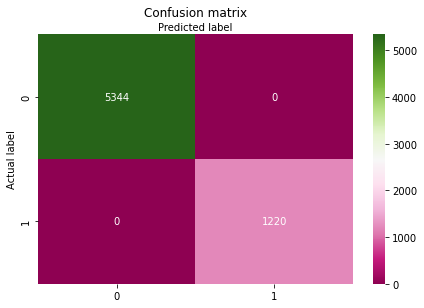

In [ ]:
# 4.3 - Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="PiYG" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# 4.2 - Import the metrics class
from sklearn import metrics
y_pred=clf_xgb.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5344,    0],
       [   0, 1220]])

In [ ]:
# 4.4 - Confusion Matrix Evaluation Metrics (NOTE: classification rate of 80%, considered as good accuracy)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


**Optimize Parameters using Cross Validation and GridSearch()**

In [ ]:
# Improve accuracy with Testing Dataset
# When data are imablanced, the XGBoost manual says: if we care only about the overall performance metric(AUC) of our prediction:
# Balance the postive and negative weights via scale_pos_weight. Use AUC for evaluation 

**k-fold Cross Validation using XGBoost**

In [ ]:
# In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the 
# original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. 
# XGBoost supports k-fold cross validation via the cv() method. All we need to do is specify the nfolds parameter, 
# which is the number of cross validation sets you want to build. 

# 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. 
# Note that we are using the Dmatrix object we created before.
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[16:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# cv_results contains train and test RMSE metrics for each boosting round.
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.469547,0.000348,0.469698,0.000289
1,0.446408,0.005073,0.446803,0.004027
2,0.432488,0.005494,0.432957,0.004231
3,0.420366,0.005039,0.420850,0.003551
4,0.400112,0.017792,0.400759,0.017521


In [ ]:
# Extract and print the final boosting round metric.
# Results:  The RMSE for the price prediction has reduced as compared to last time and came out to be around 0.11 per 1000$. 
# We can reach an even lower RMSE for a different set of hyper-parameters. We can consider applying techniques like Grid Search, 
# Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters.
print((cv_results["test-rmse-mean"]).tail(1))

49    0.119607
Name: test-rmse-mean, dtype: float64


In [ ]:
# We can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. 
# XGBoost has a plot_tree() function that makes this type of visualization easy. Once we train a model using the XGBoost learning API, 
# we can pass it to the plot_tree() function along with the number of trees we want to plot using the num_trees argument.
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[16:12:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


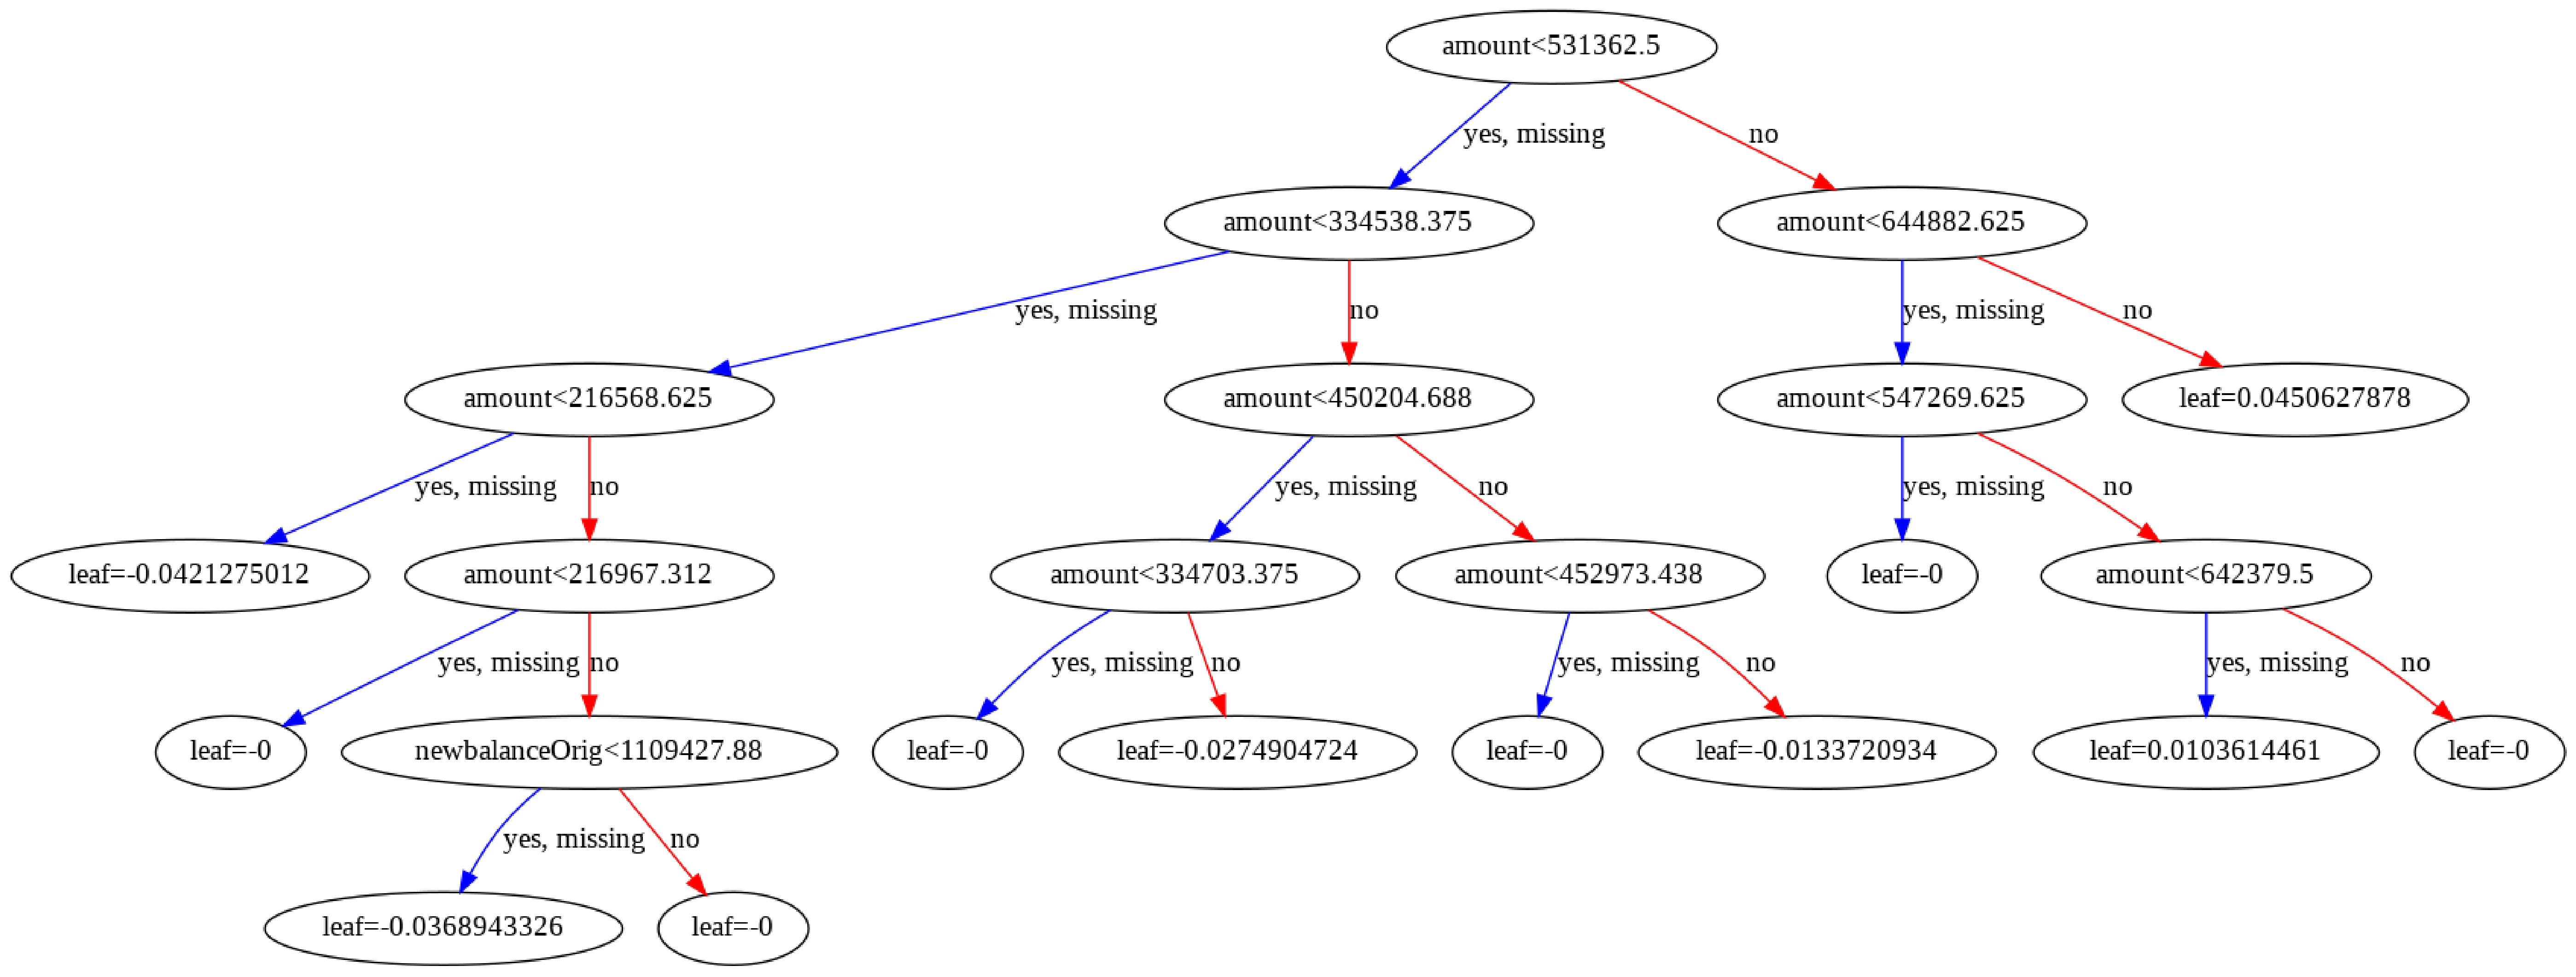

In [ ]:
# Plotting the first tree with the matplotlib library:
# These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 50]
plt.show()

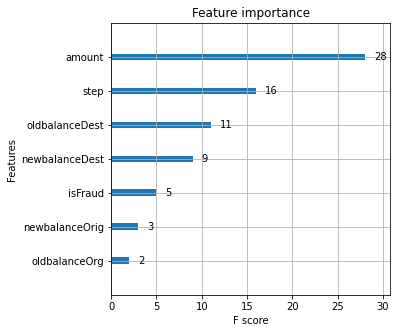

In [ ]:
# Visualizing the result as a bar graph, with the features ordered according to how many times they appear. 
# XGBoost has a plot_importance() function that allows us to do exactly this.
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 1]
plt.show()

**Building Final XGBoost Model**

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0.25,
                            learn_rate=0.1,
                            max_depth=4,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:1
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:1
[2]	validation_0-aucpr:1
[3]	validation_0-aucpr:1
[4]	validation_0-aucpr:1
[5]	validation_0-aucpr:1
[6]	validation_0-aucpr:1
[7]	validation_0-aucpr:1
[8]	validation_0-aucpr:1
[9]	validation_0-aucpr:1
[10]	validation_0-aucpr:1
Stopping. Best iteration:
[0]	validation_0-aucpr:1



XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              reg_lambda=10, scale_pos_weight=3, seed=42, subsample=0.9)

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0.25,
                            learn_rate=0.1,
                            max_depth=4,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1) # set this to 1 so we can get gain, cover etc.)
clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print('%s: '%importance_type, bst.get_score(importance_type=importance_type))

node_params = {'share': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'share': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_tree=0, size="10,10",
                codition_node_params=node_params,
                leaf_node_params=leaf_params)

*****Extra Codes for Reference**

In [ ]:
# 5. Create Train and Test Datasets: 70% of original dadta and 30% for testing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
x = data_scaled.loc[:, data_scaled.columns != 'isFraud']
y = data_scaled.loc[:, data_scaled.columns == 'isFraud']

x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(x,y,test_size = 0.3, random_state = 0)

label_encoder = LabelEncoder()
y_train_original = label_encoder.fit_transform(y_train_original.values.ravel())
y_test_original = label_encoder.fit_transform(y_test_original.values.ravel())

In [ ]:
# SMOT : https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# SMOT : https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

**XGBoost**


*   XGBoost is short for dXtreme Gradient Boosting
*   Is is an ensemble model; ensemble models combiines different machine learning models into one
*   instead of aggregating predictions, boosters turn weak learners into strong learners by focusing on where the individual models went wrong
*   XGBoost trains upon the redisudals. Instead of aggregating trees, gradient boosted trees learns from eror during each boosting round





**Confusion Matrix** - See how the model performs on the  Testing DAtaset by running the Testing Dataset down the model and drawing a Confusion Matrix

In [ ]:
!pip install xgboost
from sklearn.model_selection import RandomizedSearchCV
import xgboost
feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable
classifier = xgboost.XGBClassifier(tree_method = 'gpu_hist')

params = {
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_deph":[2,3,4,5,6,8,10,12,15],
    "min_child_weight": [1,3,5,7],
    "gamma": [0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree": [0.3,0.4,0.5,0.7]}

clf = RandomizedSearchCV(classifier,param_distributions = params, n_iter=5, scoring='roc_auc', cv=5, verbose = 3)

#fitting it
clf_xgb.fit(X,y)

#clf_xgb.best_params_


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              n_estimators=1, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9)

In [ ]:
# The best_estimator_ field contains the best model trained by GridSearch.
# https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
clf.best_estimator_
#clf_xgb.fit(X_train, y_train)
#print(clf_xgb.best_estimator_)

XGBClassifier(colsample_bytree=0.3, gamma=0.2, learning_rate=0.3, max_deph=4,
              min_child_weight=5, tree_method='gpu_hist')

In [ ]:
# Fitting the mdoel with the best parameters
final_model = xgboost.XGBClassifier(colsample_bytree=0.3, gamma=0.2, learn_rate=0.3, max_depth=4,
              n_estimators=1, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9)

In [ ]:
# Fitting it
final_model.fit(X,y)

pred_xgboost = final_model.predict(X)

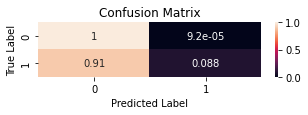

In [ ]:
# Confusion Matrix
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(cm, classes=None, title="Confusion Matrix"):
  if classes is not None:
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':10})
  else:
    sns.heatmap(cm, vmin=0., vmax=1.)
  plt.title(title)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=final_model.classes_, title="Confusion Matrix")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


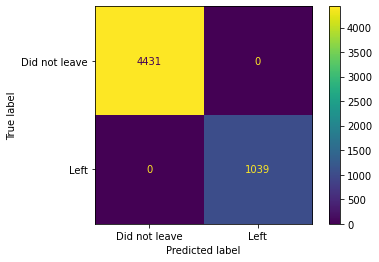

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Did not leave", "Left"])
#fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(your_model, X_test, y_test, ax=ax)

In [ ]:
clf.best_estimator_

In [ ]:
#Separate the target variable and rest of the variables using .iloc to subset the data.
#X, y = df.iloc[:,:-1],df.iloc[:,-1]

In [ ]:
#Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 
#You will use this later in the tutorial.
#data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
# Use get_dummies to convert categorical columns
# https://www.bing.com/videos/search?q=XGBoost+in+Python+from+Start+to+Finish+-+YouTube&view=detail&mid=690E97BB3131F954B74E690E97BB3131F954B74E&FORM=VIRE
# min:31 - howeve we've already conversted prior see step 3. Creating Dummy Variables
X_encoded = pd.get_dummies(X, columns= 'type'])
X_encoded.head()